In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
"""
New Data
"""

#data = pd.read_csv("traj_data_v2.csv")
data = pd.read_csv("traj_data_v2_100_seq.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,149950.000000,151.187826,-33.894480,0.000001,0.000001
std,86602.684716,86602.679905,0.002236,0.001248,0.000045,0.000022
min,0.000000,0.000000,151.184833,-33.895620,-0.000128,-0.000090
25%,74999.750000,74975.000000,151.186473,-33.895169,-0.000023,-0.000012
50%,149999.500000,149950.000000,151.187480,-33.894783,0.000000,0.000000
75%,224999.250000,224925.000000,151.188458,-33.894342,0.000026,0.000015
max,299999.000000,299900.000000,151.194604,-33.889197,0.000133,0.000089


In [7]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [8]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = 100, input_len = 20)

In [9]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

(2100, 1, 20)
(2100, 1, 78)
(2100, 20, 1)
(2100, 78, 1)


In [10]:
print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(900, 1, 20)
(900, 1, 78)
(900, 20, 1)
(900, 78, 1)


In [10]:
"""
def make_one_hot(inp):
  result = []
  for i in inp:
    inner = []
    for bin in i:
      one_hot_vector = np.zeros(((100*100) + 50), dtype= np.uint16)
      one_hot_vector[bin] = 1
      inner.append(one_hot_vector)
    result.append(inner)
  return np.array(result)
"""

In [11]:
"""
ti = make_one_hot(train_data_inputs)
tt = make_one_hot(train_data_targets)
val_in = make_one_hot(test_data_inputs) 
val_tar = make_one_hot(test_data_targets)
"""

In [11]:
print(val_in.shape, val_tar.shape)

NameError: name 'val_in' is not defined

In [16]:
vocab_size = (100 * 100) + 100
input_len = 20
target_len = 78

In [17]:
train_data_inputs.shape

(2100, 20, 1)

In [21]:
#https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/

model = Sequential()
model.add(tf.keras.layers.Input(shape=(input_len,)))
model.add(tf.keras.layers.Embedding(vocab_size, 256))#, input_length = input_len))

model.add(LSTM(128, activation='tanh', return_sequences=False, stateful=False, dropout=0.30))
model.add(RepeatVector(target_len))
model.add(LSTM(128, return_sequences=True, activation='tanh', stateful=False, dropout=0.30))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
          
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 256)           2585600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 78, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 78, 128)           131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 78, 10100)         1302900   
Total params: 4,217,204
Trainable params: 4,217,204
Non-trainable params: 0
_________________________________________________________________


In [31]:
model_results = model.fit(train_data_inputs, train_data_targets, batch_size=10, epochs=10, validation_data=(test_data_inputs, test_data_targets))

Epoch 1/10
210/210 [==============================] - 8s 37ms/step - loss: 2.1670 - accuracy: 0.4062 - val_loss: 2.4276 - val_accuracy: 0.3948
Epoch 2/10
210/210 [==============================] - 8s 37ms/step - loss: 2.1611 - accuracy: 0.4066 - val_loss: 2.4138 - val_accuracy: 0.4030
Epoch 3/10
210/210 [==============================] - 7s 35ms/step - loss: 2.1544 - accuracy: 0.4091 - val_loss: 2.4011 - val_accuracy: 0.4145
Epoch 4/10
210/210 [==============================] - 7s 35ms/step - loss: 2.1424 - accuracy: 0.4122 - val_loss: 2.4279 - val_accuracy: 0.3956
Epoch 5/10
210/210 [==============================] - 7s 35ms/step - loss: 2.1305 - accuracy: 0.4134 - val_loss: 2.3870 - val_accuracy: 0.4126
Epoch 6/10
210/210 [==============================] - 7s 35ms/step - loss: 2.1278 - accuracy: 0.4140 - val_loss: 2.3841 - val_accuracy: 0.4105
Epoch 7/10
210/210 [==============================] - 7s 35ms/step - loss: 2.1412 - accuracy: 0.4122 - val_loss: 2.3933 - val_accuracy: 0.4077

In [120]:
p = model.predict(test_data_inputs[0:1])
print(p.shape)
print(p)

(1, 28, 10100)
[[[1.90808738e-08 1.59524323e-08 1.62830833e-08 ... 1.83623978e-08
   1.63146687e-08 1.78961610e-08]
  [1.27548510e-11 9.78638785e-12 9.57687835e-12 ... 1.30156736e-11
   1.00446014e-11 1.23078900e-11]
  [6.63121739e-13 4.81524434e-13 4.73411187e-13 ... 6.89232525e-13
   4.97545527e-13 6.66254486e-13]
  ...
  [1.62705526e-11 1.02049688e-11 8.59467445e-12 ... 1.27361906e-11
   7.76662675e-12 1.08663035e-11]
  [1.58316762e-11 1.00681017e-11 8.24717898e-12 ... 1.23831284e-11
   7.68343462e-12 1.09216533e-11]
  [1.37306772e-11 9.18026506e-12 7.29539693e-12 ... 1.09854114e-11
   7.08467009e-12 9.78577202e-12]]]


In [44]:
model.save('LSTM_100seq.h5')

In [16]:
model = keras.models.load_model('newencoder_decoder.h5')

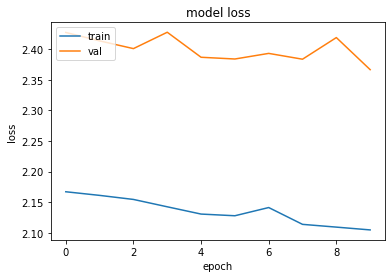

In [33]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(model_results.history['loss'])
plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
input_len = 20
target_len = 28

In [34]:
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        res = model.predict(data_source_inputs[i:i+1])
        for j in range(target_len):
            ground_truths.append(data_source_targets[i].squeeze().tolist())
            predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
            if j < 20:
                inputs.append(int(data_source_inputs[i][j]))
            
    return inputs, ground_truths, predictions

In [35]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [37]:
len(inputs_list)

18000

In [38]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds)
    err += dist
  return (err / len(targets))

In [39]:
calculate_eucledian_mse(target_list, preds_list)

TypeError: unsupported operand type(s) for %: 'list' and 'int'

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
    plt.figure(figsize=(3,3))
    for i in range(0, len(input_list)):

        inputs = input_list[i]
        targets = target_list[i]
        preds = preds_list[i]
        
        xy_inputs = []
        xy_preds = []
        xy_target = []

        x = inputs % 100
        y = inputs / 100 
        xy_inputs.extend([x, y])

        x = preds % 100
        y = preds / 100 
        xy_preds.extend([x, y])

        x = targets % 100
        y = targets / 100 
        xy_target.extend([x, y])
    print(xy_inputs)
    print(xy_preds)
    print(xy_target)
    """

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)
    time.sleep(lag_time)
    """

In [43]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

TypeError: unsupported operand type(s) for %: 'list' and 'int'

<Figure size 216x216 with 0 Axes>

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
  
  for i in range(1 ,1000, 20):

    plt.figure(figsize=(5,5))
    #inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    """
    for inp in inputs:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])
    """
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    #x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    #plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)


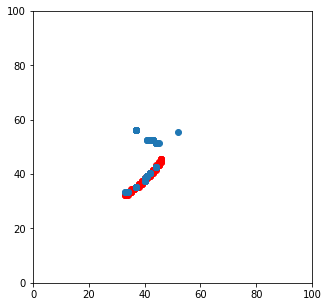

Input:  []
Preds:  [[52, 55.52], [45, 51.45], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [41, 52.41], [41, 52.41], [41, 52.41], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [40, 38.4], [40, 38.4], [40, 37.4], [40, 37.4], [40, 37.4], [40, 37.4], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [34, 33.34], [34, 33.34]

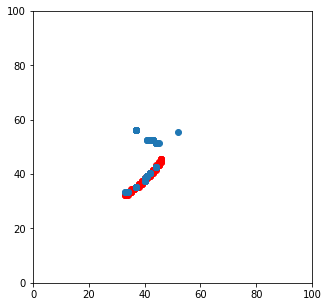

Input:  []
Preds:  [[52, 55.52], [45, 51.45], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [41, 52.41], [41, 52.41], [41, 52.41], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [40, 38.4], [40, 38.4], [40, 37.4], [40, 37.4], [40, 37.4], [40, 37.4], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [34, 33.34], [34, 33.34]

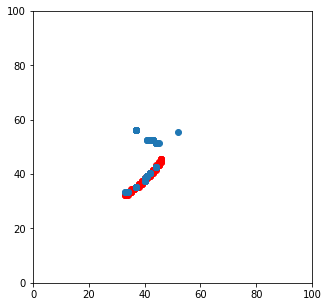

Input:  []
Preds:  [[52, 55.52], [45, 51.45], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [41, 52.41], [41, 52.41], [41, 52.41], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [40, 38.4], [40, 38.4], [40, 37.4], [40, 37.4], [40, 37.4], [40, 37.4], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [34, 33.34], [34, 33.34]

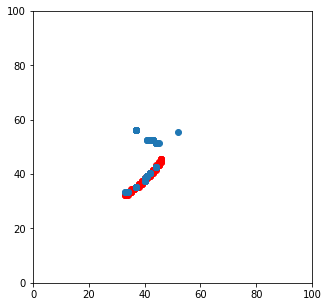

Input:  []
Preds:  [[52, 55.52], [45, 51.45], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [44, 51.44], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [43, 52.43], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [42, 52.42], [41, 52.41], [41, 52.41], [41, 52.41], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [44, 42.44], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [42, 40.42], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [37, 56.37], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [41, 39.41], [40, 38.4], [40, 38.4], [40, 37.4], [40, 37.4], [40, 37.4], [40, 37.4], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [37, 35.37], [34, 33.34], [34, 33.34]

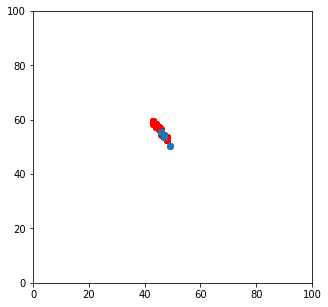

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 

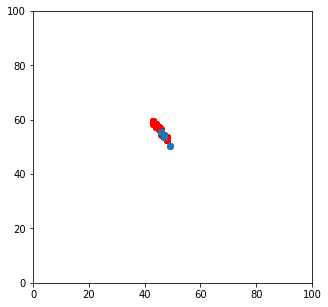

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 

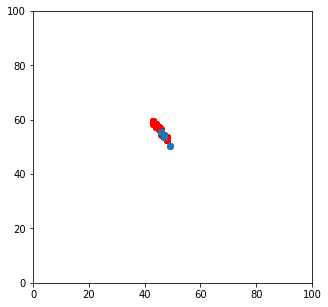

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 

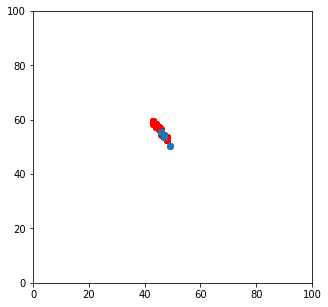

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 

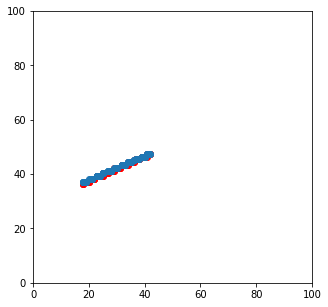

Input:  []
Preds:  [[42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [41, 47.41], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 45.36], [36, 45.36], [36, 45.36], [35, 44.35], [35, 44.35], [35, 44.35], [35, 44.35], [34, 44.34], [34, 44.34], [34, 44.34], [33, 43.33], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [30, 42.3], [30, 42.3], [30, 42.3], [30, 42.3], [29, 42.29], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [27, 41.27], [27, 41.27], [27, 41.27], [27, 41.27], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [24, 39.24], [24, 39.24], [24, 39.24], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [21, 38.21], [21, 38.21], [21, 38.21], [21, 38.21], [20, 38.2], [19, 37.19], [19, 37.19], [19, 37.19], [18, 37.18], [18, 37.18], 

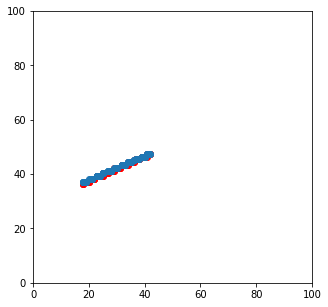

Input:  []
Preds:  [[42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [41, 47.41], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 45.36], [36, 45.36], [36, 45.36], [35, 44.35], [35, 44.35], [35, 44.35], [35, 44.35], [34, 44.34], [34, 44.34], [34, 44.34], [33, 43.33], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [30, 42.3], [30, 42.3], [30, 42.3], [30, 42.3], [29, 42.29], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [27, 41.27], [27, 41.27], [27, 41.27], [27, 41.27], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [24, 39.24], [24, 39.24], [24, 39.24], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [21, 38.21], [21, 38.21], [21, 38.21], [21, 38.21], [20, 38.2], [19, 37.19], [19, 37.19], [19, 37.19], [18, 37.18], [18, 37.18], 

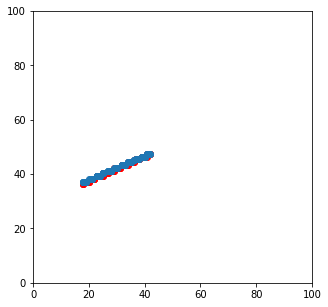

Input:  []
Preds:  [[42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [41, 47.41], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 45.36], [36, 45.36], [36, 45.36], [35, 44.35], [35, 44.35], [35, 44.35], [35, 44.35], [34, 44.34], [34, 44.34], [34, 44.34], [33, 43.33], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [30, 42.3], [30, 42.3], [30, 42.3], [30, 42.3], [29, 42.29], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [27, 41.27], [27, 41.27], [27, 41.27], [27, 41.27], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [24, 39.24], [24, 39.24], [24, 39.24], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [21, 38.21], [21, 38.21], [21, 38.21], [21, 38.21], [20, 38.2], [19, 37.19], [19, 37.19], [19, 37.19], [18, 37.18], [18, 37.18], 

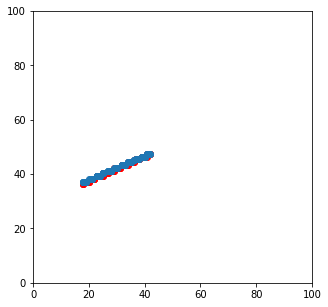

Input:  []
Preds:  [[42, 47.42], [42, 47.42], [41, 47.41], [41, 47.41], [41, 47.41], [41, 47.41], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [39, 46.39], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 45.37], [36, 45.36], [36, 45.36], [36, 45.36], [35, 44.35], [35, 44.35], [35, 44.35], [35, 44.35], [34, 44.34], [34, 44.34], [34, 44.34], [33, 43.33], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [32, 43.32], [30, 42.3], [30, 42.3], [30, 42.3], [30, 42.3], [29, 42.29], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [28, 41.28], [27, 41.27], [27, 41.27], [27, 41.27], [27, 41.27], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [25, 40.25], [24, 39.24], [24, 39.24], [24, 39.24], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [23, 39.23], [21, 38.21], [21, 38.21], [21, 38.21], [21, 38.21], [20, 38.2], [19, 37.19], [19, 37.19], [19, 37.19], [18, 37.18], [18, 37.18], 

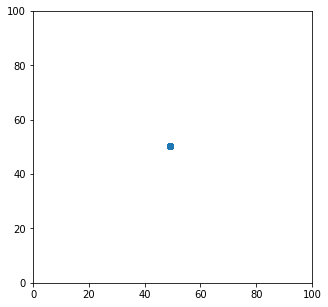

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 

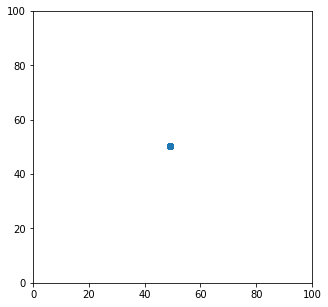

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 

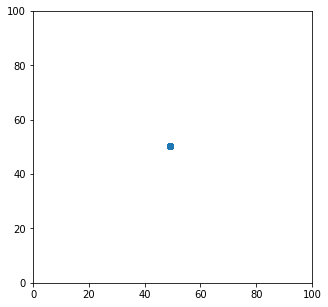

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 

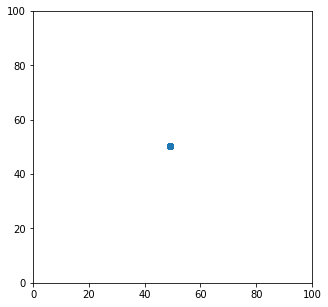

Input:  []
Preds:  [[49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 50.49], [49, 

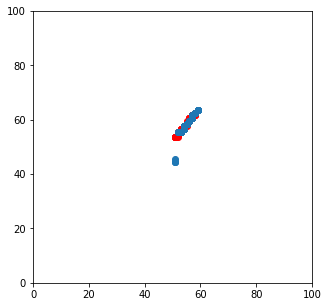

Input:  []
Preds:  [[51, 45.51], [51, 44.51], [51, 44.51], [51, 44.51], [52, 55.52], [52, 55.52], [52, 55.52], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 61.57], [57, 61.57], [57, 61.57], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 

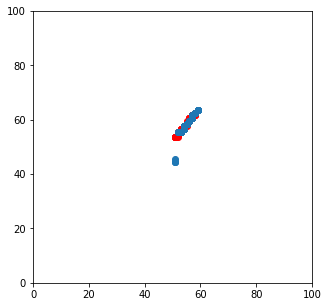

Input:  []
Preds:  [[51, 45.51], [51, 44.51], [51, 44.51], [51, 44.51], [52, 55.52], [52, 55.52], [52, 55.52], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 61.57], [57, 61.57], [57, 61.57], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 

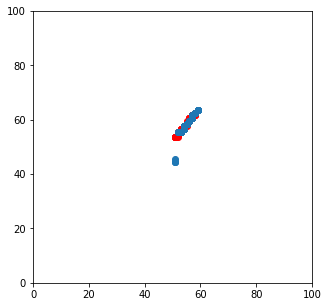

Input:  []
Preds:  [[51, 45.51], [51, 44.51], [51, 44.51], [51, 44.51], [52, 55.52], [52, 55.52], [52, 55.52], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 61.57], [57, 61.57], [57, 61.57], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 

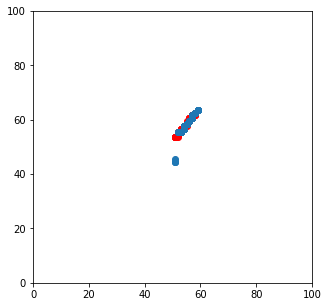

Input:  []
Preds:  [[51, 45.51], [51, 44.51], [51, 44.51], [51, 44.51], [52, 55.52], [52, 55.52], [52, 55.52], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [53, 55.53], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 56.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [55, 58.55], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [56, 59.56], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 60.57], [57, 61.57], [57, 61.57], [57, 61.57], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [58, 62.58], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 63.59], [59, 

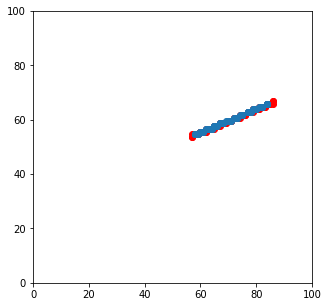

Input:  []
Preds:  [[58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [59, 54.59], [59, 54.59], [59, 54.59], [60, 55.6], [60, 55.6], [60, 55.6], [61, 55.61], [61, 55.61], [61, 55.61], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [63, 56.63], [64, 56.64], [64, 56.64], [65, 57.65], [65, 57.65], [65, 57.65], [65, 57.65], [66, 57.66], [66, 57.66], [67, 58.67], [67, 58.67], [67, 58.67], [68, 58.68], [68, 58.68], [68, 58.68], [68, 58.68], [69, 59.69], [70, 59.7], [70, 59.7], [70, 59.7], [70, 59.7], [71, 59.71], [71, 59.71], [72, 60.72], [72, 60.72], [73, 60.73], [73, 60.73], [73, 60.73], [73, 60.73], [74, 61.74], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [78, 62.78], [78, 62.78], [79, 63.79], [79, 63.79], [80, 63.8], [80, 63.8], [80, 63.8], [80, 63.8], [81, 64.81], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [84, 65.84], [84, 65.84], [84, 65.84], [84, 65.84], [84

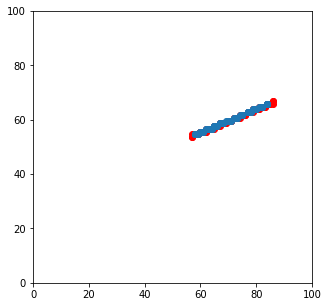

Input:  []
Preds:  [[58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [59, 54.59], [59, 54.59], [59, 54.59], [60, 55.6], [60, 55.6], [60, 55.6], [61, 55.61], [61, 55.61], [61, 55.61], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [63, 56.63], [64, 56.64], [64, 56.64], [65, 57.65], [65, 57.65], [65, 57.65], [65, 57.65], [66, 57.66], [66, 57.66], [67, 58.67], [67, 58.67], [67, 58.67], [68, 58.68], [68, 58.68], [68, 58.68], [68, 58.68], [69, 59.69], [70, 59.7], [70, 59.7], [70, 59.7], [70, 59.7], [71, 59.71], [71, 59.71], [72, 60.72], [72, 60.72], [73, 60.73], [73, 60.73], [73, 60.73], [73, 60.73], [74, 61.74], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [78, 62.78], [78, 62.78], [79, 63.79], [79, 63.79], [80, 63.8], [80, 63.8], [80, 63.8], [80, 63.8], [81, 64.81], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [84, 65.84], [84, 65.84], [84, 65.84], [84, 65.84], [84

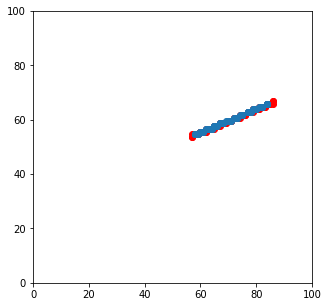

Input:  []
Preds:  [[58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [58, 54.58], [59, 54.59], [59, 54.59], [59, 54.59], [60, 55.6], [60, 55.6], [60, 55.6], [61, 55.61], [61, 55.61], [61, 55.61], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [63, 56.63], [64, 56.64], [64, 56.64], [65, 57.65], [65, 57.65], [65, 57.65], [65, 57.65], [66, 57.66], [66, 57.66], [67, 58.67], [67, 58.67], [67, 58.67], [68, 58.68], [68, 58.68], [68, 58.68], [68, 58.68], [69, 59.69], [70, 59.7], [70, 59.7], [70, 59.7], [70, 59.7], [71, 59.71], [71, 59.71], [72, 60.72], [72, 60.72], [73, 60.73], [73, 60.73], [73, 60.73], [73, 60.73], [74, 61.74], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [75, 61.75], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [77, 62.77], [78, 62.78], [78, 62.78], [79, 63.79], [79, 63.79], [80, 63.8], [80, 63.8], [80, 63.8], [80, 63.8], [81, 64.81], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [82, 64.82], [84, 65.84], [84, 65.84], [84, 65.84], [84, 65.84], [84

KeyboardInterrupt: 

In [41]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [63]:
target_list[3]

[6943,
 7042,
 7142,
 7242,
 7341,
 7441,
 7541,
 7541,
 7640,
 7740,
 7840,
 7939,
 8039,
 8139,
 8238,
 8338,
 8438,
 8538,
 8637,
 8737,
 8837,
 8936,
 8936,
 9036,
 9135,
 9235,
 9335,
 9435]

In [ ]:
def get_coordinates():
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)
    
    return xy_inputs, xy_preds, xy_target

In [ ]:
xy_in, xy_preds, xy_tar = get_coordinates()

In [ ]:
output_df[['X_REAL', 'Y_REAL']] = scaler.inverse_transform(output_df[['X_REAL', 'Y_REAL']])
output_df[['X_PRED', 'Y_PRED']] = scaler.inverse_transform(output_df[['X_PRED', 'Y_PRED']])

In [ ]:
for inp in test_indx[0]:
    print(inp)